In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import argparse
import os
from sklearn.model_selection import train_test_split
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import os
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import random
import torchvision.transforms as transforms
import argparse
from tqdm import tqdm
import PIL.Image as Image
import torch
import torchvision.models as models
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from torch.utils.data import TensorDataset, DataLoader,Dataset
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import cv2
from skimage.transform import resize
import natsort
from functools import partial
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
!pip install -q celery
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/SinGAN2-main


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/SinGAN2-main'
/content/drive/MyDrive/SinGAN2-main


# Model

In [7]:
nclasses = 9 
main_path = '/content/drive/My Drive/SinGAN2-main/'
class my_FCN(nn.Module):
    def __init__(self, pretrained_model):
        super(my_FCN, self).__init__()
        self.backbone = torch.nn.Sequential(*list(pretrained_model.children())[:-2])
        
        self.Classifer =torch.nn.Sequential(nn.Conv2d(2048, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(512, 9, 1))
        
    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.backbone(x)['out']
        x = self.Classifer(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

# Generating sketchs

In [8]:
pretrained = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True)
pretrained.eval()
# ct = 0
# for child in pretrained.children():
#   ct += 1
#   if 0<ct<2:
#     for param in child.parameters():
#         param.requires_grad = False

model = my_FCN(torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True))
model.load_state_dict(torch.load('/content/drive/My Drive/SinGAN-Project/training_data_seg/model_seg_aug_free_exact_mask_3.pth'))
#the model was trained for 700
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


my_FCN(
  (backbone): Sequential(
    (0): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

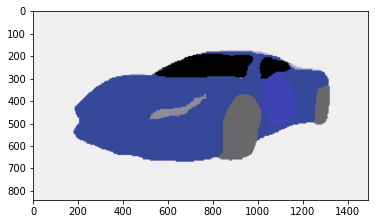

In [9]:
transform_m = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

transform_p = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dic = {}
dic['backround']   = 0
dic['unk'] = 1
dic['frontside']   = 2
dic['leftside']    = 2
dic['rightside']   = 2
dic['backside']    = 2
dic['roofside']    = 2
dic['leftmirror']  = 3
dic['rightmirror'] = 3   
dic['fliplate']    = 4 
dic['bliplate']    = 4     
for ii in range(1, 10 + 1):
    dic[('door_%d' % ii)] = 5
for ii in range(1, 10 + 1):
    dic[('wheel_%d' % ii)] = 6
for ii in range(1, 10 + 1):
    dic[('headlight_%d' % ii)] = 7
for ii in range(1, 20 + 1):
    dic[('window_%d' % ii)] = 8



def pil_loader(path):
      with open(path, 'rb') as f:
          with Image.open(f) as img:
              return img.convert('RGB')

def get_sketch(path_image,model,transform_m,pretrained,transform_p):
    image = pil_loader(path_image)
    tensor_im = transform_p(image)[None,:,:,:]
    mask_car = pretrained(tensor_im)['out'][0].argmax(0)
    mask_car[mask_car>0] = 1
    image = np.array(image)
    img_crp = np.zeros_like(image)
    img_crp[np.where(mask_car>0)[0],np.where(mask_car>0)[1],:] = image[np.where(mask_car>0)[0],np.where(mask_car>0)[1],:]
    tensor_im = transform_m(image)[None,:,:,:]
    out = torch.argmax(model(tensor_im),dim=1).cpu()[0].numpy()
    return resize(out, (image.shape[0], image.shape[1]), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')


def get_all_sketchs(path_test_images,path_train_image,model,transform_m,pretrained,transform_p,labels_dict):
    dic_colors_train = {}
    sketchs = []
    orientation_train = 'right'
    sketch_image_train = get_sketch(path_train_image,model,transform_m,pretrained,transform_p)    
    labels_train = np.unique(sketch_image_train)
    image_train = np.array(pil_loader(path_train_image))

    # 7 label of head lights
    # 6 label of wheels
    wheel_ind = np.mean(np.where(sketch_image_train==6)[1])
    lights_ind = np.mean(np.where(sketch_image_train==7)[1])
    if wheel_ind > lights_ind:
      orientation_train = 'left'
    for l in labels_train:    
      mean = np.mean(random.choices(image_train[sketch_image_train==l], k = 10000),axis = 0)
      dic_colors_train[l] = mean.astype(int)
    dic_colors_train[l] =[0,0,0]
    del image_train
    del sketch_image_train

    for i, path in enumerate(path_test_images):
      orientation_test = 'right'
      sketch = get_sketch(path,model,transform_m,pretrained,transform_p)
      wheel_ind = np.mean(np.where(sketch==6)[1])
      lights_ind = np.mean(np.where(sketch==7)[1])
      if wheel_ind > lights_ind:
        orientation_test = 'left'
      color_sketch = np.zeros((sketch.shape[0],sketch.shape[1],3)).astype(int)
      for l in labels_train :
        if l in dic_colors_train.keys():
          color_sketch[sketch==l]=dic_colors_train[l]
      

      if orientation_test != orientation_train:
        color_sketch = cv2.flip(color_sketch, 1)

      color_sketch= cv2.resize(color_sketch.astype('float32') , dsize=(5*color_sketch.shape[1],5*color_sketch.shape[0]), interpolation=cv2.INTER_NEAREST)
      color_sketch = Image.fromarray(np.uint8(color_sketch))


      plt.imshow(color_sketch)
      plt.show()
      try:
        color_sketch.save(f'{main_path}/data/paint/{os.path.basename(path_train_image)[:-4]}/{os.path.basename(path_train_image)[:-4]}_sketch_{os.path.basename(path)}')
      except OSError:
        try:
          os.makedirs(f'{main_path}/data/paint/{os.path.basename(path_train_image)[:-4]}/')
          color_sketch.save(f'{main_path}/data/paint/{os.path.basename(path_train_image)[:-4]}/{os.path.basename(path_train_image)}_sketch_{os.path.basename(path)}')
        except Exception:
          print('Folder not created')
      #sketchs.append(color_sketch)
    return 
  
path_train = f'{main_path}/data/images/'
path_test = f'{main_path}/data/images/'
path_test_images = [path_test+f for f in os.listdir(path_test)]
for image in os.listdir(path_train):
  path_train_image = path_train+image
  get_all_sketchs(path_test_images,path_train_image,model,transform_m,pretrained,transform_p,dic)

# Applying SinGAN


In [ ]:
# !git clone -b Yassine https://github.com/YassineNJ/SinGAN-Project.git
# !pip install torch==1.4.0 torchvision==0.5.0


/content/drive/MyDrive/SinGAN2-main


In [ ]:
main_path = '/content/drive/My Drive/SinGAN2-main/data'

!python main_train.py --img ferariblue.png --N 8 --steps_per_scale 2000 --run_name   ferariblue_N8_NS2000_dstep10_gstep5 --grad_penalty True

Gradient penalty = True
Using sinkhorn loss =  False
2021-01-11 14:36:41.439566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Grad penalty= True Sinkhorn = False
[(16, 29), (22, 39), (29, 53), (39, 70), (53, 94), (70, 125), (94, 167), (126, 223), (168, 298)]
After operation img size is torch.Size([1, 3, 168, 298])
Input shape =  torch.Size([1, 3, 168, 298])
[1.0]
[8: 100|2000] - {'adv_d_fake_loss': -1.8863131999969482, 'adv_d_real_loss': 0.17170129716396332, 'adv_g_loss': 2.105365514755249, 'rec_g_loss': 0.04330748692154884}
[8: 200|2000] - {'adv_d_fake_loss': -2.242999315261841, 'adv_d_real_loss': 0.21794408559799194, 'adv_g_loss': 2.4747893810272217, 'rec_g_loss': 0.04209073632955551}
[8: 300|2000] - {'adv_d_fake_loss': -3.420224666595459, 'adv_d_real_loss': 1.0208073854446411, 'adv_g_loss': 3.7571871280670166, 'rec_g_loss': 0.023853275924921036}
[8: 400|2000] - {'adv_d_fake_loss': -4.362461566925049, 'adv_d_rea

In [ ]:
main_path = '/content/drive/My Drive/SinGAN2-main/data'
for f in os.listdir(main_path + '/paint/hyper_example/'):
  !python paint2image.py --run_name ferariblue_N8_NS2000_dstep10_gstep5  --folder hyper_example --paint {f}

2021-01-11 16:01:09.667836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Grad penalty= True Sinkhorn = False
2021-01-11 16:01:18.984014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Grad penalty= True Sinkhorn = False


# Evaluation

In [ ]:
!python sifid_score.py --path2real {"imgs_real_singan_original"}  --path2fake {"original"} --original True

imgs_real_singan_original/best_test2.jpg
______________________________
file image19.jpg  folder  : best_test2_out_N3000_r09
sifid sketch :  0.7553466428287532
sifid real :  1.2750404899574832
our metric 2.5500809799149664
______________________________
______________________________
file image20.jpg  folder  : best_test2_out_N3000_r09
sifid sketch :  0.38124908074517094
sifid real :  0.38181434537736436
our metric 0.7636286907547287
______________________________
______________________________
file image21.jpg  folder  : best_test2_out_N3000_r09
sifid sketch :  0.42181885769326044
sifid real :  0.523801416465588
our metric 1.047602832931176
______________________________
______________________________
file image22.jpg  folder  : best_test2_out_N3000_r09
sifid sketch :  0.4250961322138025
sifid real :  0.2785651980110764
our metric 0.850192264427605
______________________________
______________________________
file image23.jpg  folder  : best_test2_out_N3000_r09
sifid sketch :  0.37615